# Model validation with observation data: River discharge and Well WTD

In this notebook, the modeled river discharge (Q) and saturated zone water table depth (WTD) are compared with river gauge and well observation timeseries. The data are first loaded and spatially visualized and the timeseries of simulated and observed pairs are plotted for comparison. The package [ModelSkill](https://github.com/DHI/modelskill.git) is utilized for generating statistics (NSE, KGE, RMSE, etc.) and evaluating model performance.

<!-- IN PROGRESS:  Validate surface water extent with JRC surface water frequency map? or S2 NDWI maps? Need to see if there is any serious surface water here -->


In [55]:
# Import necessary libraries
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import mikeio
import shapely
import glob
import os
import pandas as pd
import modelskill as ms
import re


In [56]:
# Functions
def plot_settings(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    # remove plot border
    for spine in ax.spines.values():
        spine.set_visible(False)


def get_comparer(df_obs,df_mod, stationID, station_loc_df, q, stationField='stationID'):
    """Get a Comparer object for a given model and station id"""
    # create Observation objects (assuming several stations)
    df_station = df_obs[stationID]
    xloc = station_loc_df.loc[station_loc_df[stationField] == stationID].x.iloc[0]
    yloc = station_loc_df.loc[station_loc_df[stationField] == stationID].y.iloc[0]

    o = ms.PointObservation(df_station, item=None, name=stationID,
                            x=xloc, y=yloc, quantity=q)

    # create ModelResult object (assuming one model)
    m = ms.PointModelResult(df_mod[stationID], item=None, name='Skjern_100m', quantity=q)
    
    return ms.match(obs=o, mod=m)


In [57]:
# ---------------------- Station Information ----------------------
chainage_dict = {"Q250018" : -3764,
        "Q250019" : -30794,
        "Q250020" : -3681,
        "Q250021" : 3900,
        "Q250078" : 26434,
        "Q250082" : 54135,
        "Q250090" : -2400,
        "Q250092" : -10576,
        "Q250097" : 61000

}

branch_dict = {"Q250018" : 'SKJERN_AA_DK5',
        "Q250019" : 'SDR_OMME_AA_DK5',
        "Q250020" : 'HOLTUM_AA_DK5',
        "Q250021" : 'BRANDE_AA_DK5',
        "Q250078" : 'SDR_OMME_AA_DK5',
        "Q250082" : 'SKJERN_AA_DK5',
        "Q250090" : 'SDR_OMME_AA_DK5',
        "Q250092" : 'GUNDESBOEL_AA_DK5',
        "Q250097" : 'SKJERN_AA_DK5'

}

C:\Users\safr\AppData\Local\Temp\ipykernel_38936\978347585.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  river_gauge_loc = pd.concat([river_gauge_loc, loc_temp], ignore_index=True)


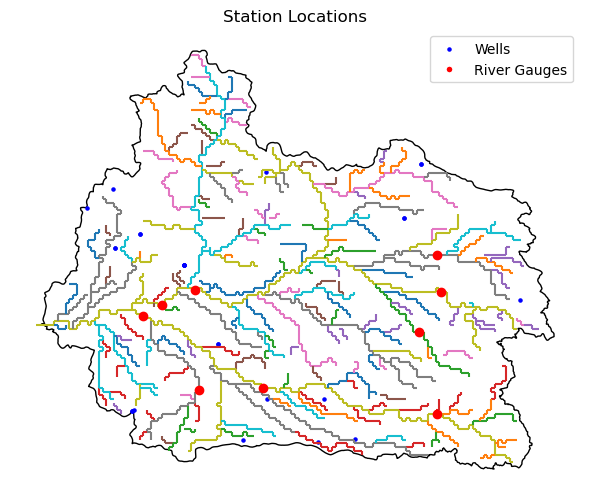

In [58]:
# ---------------------- Plot Domain, River Connectivity, Discharge stations ----------------------

fig, ax = plt.subplots(figsize=(6, 6))

# Domain data
domain_shp = gpd.read_file( r"..\input\domain\Skjern.shp")
domain_shp.plot(facecolor='none', edgecolor='black',ax=ax)

# River connectivity shapefile (simulation output)
riv_shp = gpd.read_file(r"..\output_sample\mshe_output\HIP_500m_Skjern_DHI_RiverLinks.shp")
riv_shp.plot(column='Branch',ax=ax)
plot_settings(ax)

river_gauge_loc = pd.DataFrame(columns=['stationID', 'x', 'y'])

# Plot locations of river discharge stations
for stationID in branch_dict.keys():
    branch = branch_dict[stationID]
    chainage = chainage_dict[stationID]
    river = riv_shp.loc[riv_shp['Branch'] == branch]

    # get closest chainage
    closest_chain = river.iloc[(river['Chainage']-chainage).abs().argsort()[:1]]

    # get centroid of closest_chain
    centroid = shapely.centroid(closest_chain.geometry)
    centroid.plot(ax=ax,color='red',zorder=2)
    xloc = float(centroid.x.iloc[0])
    yloc = float(centroid.y.iloc[0])

    # store x and y coordinates in a DataFrame
    loc_temp = pd.DataFrame({'stationID': [stationID], 'x': [xloc], 'y': [yloc]})
    river_gauge_loc = pd.concat([river_gauge_loc, loc_temp], ignore_index=True)

    # plot stationID next to point
    # plt.text(x=xloc,y=yloc,s=stationID)

plt.title('Station Locations')

# Read in well locations
well_loc = gpd.read_file(r"..\observations\H_data\head_elev_SZ.csv")
# rename well_loc columns X and Y to x and y
well_loc = well_loc.rename(columns={'X': 'x', 'Y': 'y'})
well_loc = gpd.GeoDataFrame(well_loc, geometry=gpd.points_from_xy(well_loc['x'], well_loc['y']))
well_loc = well_loc.set_crs(domain_shp.crs)
well_loc = gpd.sjoin(well_loc, domain_shp, how='inner', predicate='intersects') #Wells within domain
well_loc.plot(ax=ax, color='blue', markersize=5, label='Wells')

# Add legend with manually specified labels
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], marker='o', color='w', label='River Gauges', markerfacecolor='red', markersize=5))
ax.legend(handles=handles, loc='upper right')
plt.tight_layout()

In [59]:
# ---------------------- Load modeled and observed river discharge and water table depth (WTD) ----------------------


# Load Q observations
Q_obs = mikeio.read(r"..\observations\Q_data\Q_filtered.dfs0")
Q_obs = Q_obs.to_dataframe()


# Load well obs (WTD)
well_obs = pd.DataFrame()
for filename in glob.glob(r"..\observations\H_data\H_data_filtered\*.dfs0"):
    temp = mikeio.read(filename)
    temp = temp[0].to_dataframe()
    temp.columns = ['WTD']
    stationID = os.path.basename(filename)[0:-5]
    temp['StationID'] = stationID
    # set index to datetime
    temp.index = pd.to_datetime(temp.index)

    well_obs = pd.concat([well_obs, temp])

# Load modeled Q
Q_mod = mikeio.read(r"..\output_sample\mshe_output\HIP_500m_Skjern_DHIDetailedTS_M11.dfs0")
Q_mod = Q_mod.to_dataframe()

# Load modeled WTD
Wtd_SZ_mod = mikeio.read(r"..\output_sample\mshe_output\HIP_500m_Skjern_DHIDetailedTS_SZ.dfs0")
Wtd_SZ_mod = Wtd_SZ_mod.to_dataframe()


<Axes: title={'center': 'Skjern_100m vs Q250019'}, xlabel='Observation, Discharge [m3/s]', ylabel='Model, Discharge [m3/s]'>

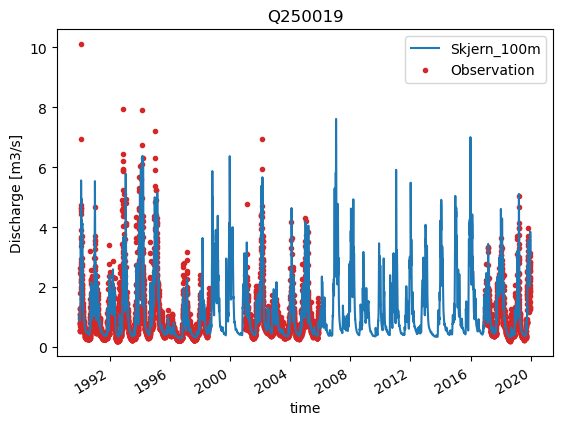

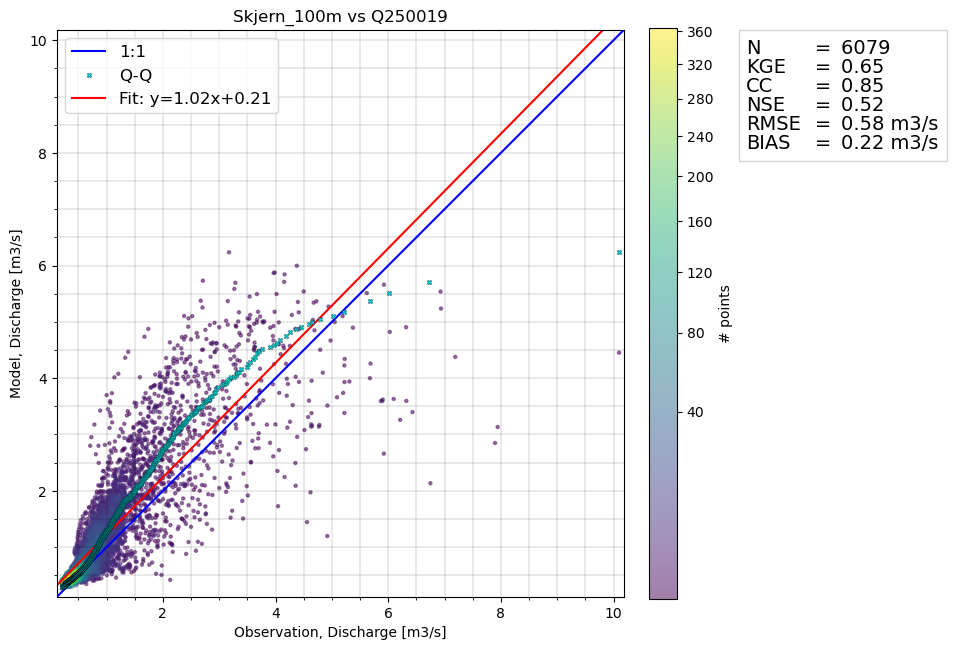

In [60]:
# ---------------------- Assess river discharge model results using ModelSkill ----------------------

stationID = 'Q250019'  # example station ID
ms.options.metrics.list = ["kge", "cc","nse","rmse","bias"]


# create Quantity object
q = ms.Quantity(name="Discharge", unit="m3/s")
cmp = get_comparer(Q_obs, Q_mod, stationID, river_gauge_loc, q,stationField='stationID')
stats = cmp.skill().round(3)

# plot timeseries
cmp.plot.timeseries()

# plot scatter plot
cmp.sel(model="Skjern_100m").plot.scatter(skill_table=True)



In [61]:
# ----------------------ModelSkill summary statistics ----------------------

showPlots = False

all_stats = pd.DataFrame()
for stationID in branch_dict.keys():
    cmp = get_comparer(Q_obs, Q_mod, stationID, river_gauge_loc, q, stationField='stationID')

    if showPlots == True:
        # plot timeseries
        cmp.plot.timeseries()
        # plot scatter plot
        cmp.sel(model="Skjern_100m").plot.scatter()

    temp_stats = cmp.skill().round(3)
    all_stats = pd.concat([all_stats,temp_stats])

print("ModelSkill Summary Statistics:")
print(all_stats)

# print average statistics across all stations
avg_stats = all_stats.mean().round(3)
print("\nAverage Statistics Across All Stations:")
print(avg_stats[['kge','cc','nse','rmse','bias']])

ModelSkill Summary Statistics:
                 n    kge     cc    nse   rmse   bias         x          y
observation                                                               
Q250018       9327  0.530  0.681  0.090  0.479 -0.306  514750.0  6201000.0
Q250019       6079  0.653  0.846  0.521  0.582  0.221  514250.0  6184500.0
Q250020      10947  0.803  0.874  0.562  0.290 -0.186  514250.0  6206000.0
Q250021      10947  0.694  0.840  0.582  0.178 -0.097  511750.0  6195500.0
Q250078      10947  0.796  0.936  0.808  2.130  0.307  474500.0  6197750.0
Q250082      10947  0.840  0.940  0.790  3.233 -1.872  481500.0  6201250.0
Q250090       5842  0.630  0.946  0.642  1.127  0.672  490750.0  6188000.0
Q250092       5842  0.657  0.771  0.584  0.536 -0.087  482000.0  6187750.0
Q250097       8392  0.776  0.917  0.673  6.236 -3.605  477000.0  6199250.0

Average Statistics Across All Stations:
kge     0.709
cc      0.861
nse     0.584
rmse    1.643
bias   -0.550
dtype: float64


### ModelSkill evaluation takeaways:

Across all river discharge stations, we have an average KGE of **0.709**, correlation of **0.861**, NSE of **0.584**, and RMSE of **1.643**. So, the model is performing much better than the benchmark mean (>-0.4 KGE and NSE>0), and the relatively high positive KGE and NSE imply that the model has decent predictive abilities. Observations and simulated values are highly correlated, and the RMSE overall is less than 2 m.

From the timeseries plots, we can see in a few cases that the model underpredicts high flows (see Q250097 and Q250090). However in most of the cases, the high flow signal is captured and occasionally overestimated (see Q250092, Q250021, Q250020, Q250018).

<Axes: title={'center': 'Skjern_100m vs 103.1653_2'}, xlabel='Observation, WTD [m]', ylabel='Model, WTD [m]'>

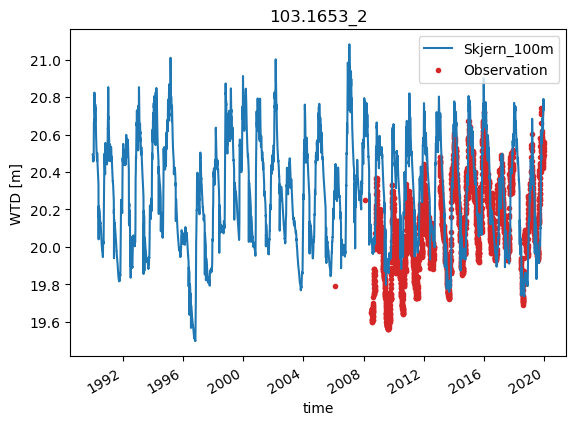

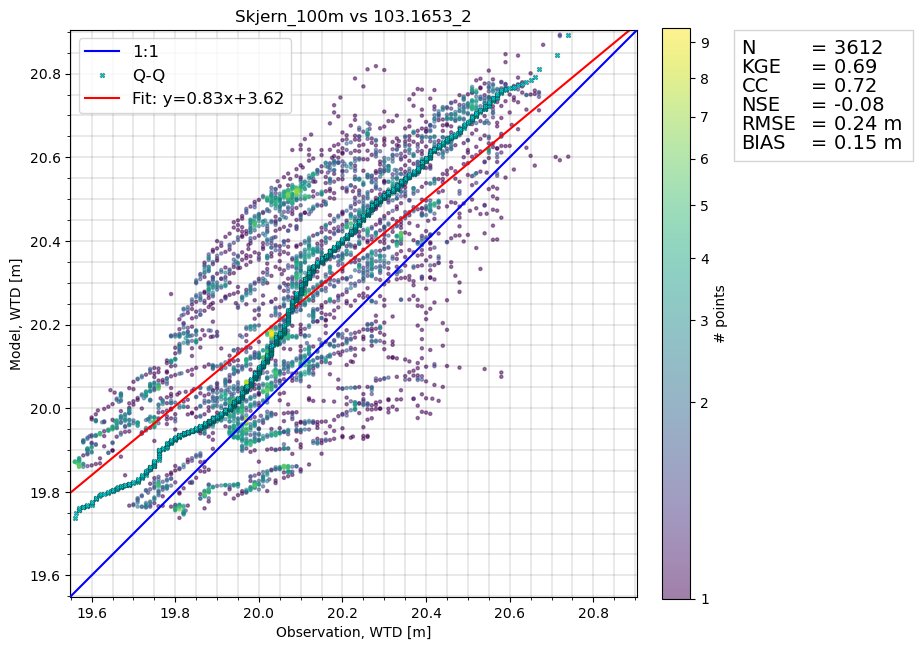

In [62]:
# ---------------------- Assess WTD model results using ModelSkill ----------------------

wellID = '103.1653_2'

# reformat to get stationID as columns
well_obs['time'] = well_obs.index
wells_obs_long = well_obs.pivot_table(index='time', columns='StationID', values='WTD')


# create Quantity object
q = ms.Quantity(name="WTD", unit="m")
cmp = get_comparer(wells_obs_long, Wtd_SZ_mod, wellID,well_loc,q,stationField='Name')
stats = cmp.skill().round(3)

# plot timeseries
cmp.plot.timeseries()

# plot scatter plot
cmp.sel(model="Skjern_100m").plot.scatter(skill_table=True)



In [63]:
# ----------------------ModelSkill WTD summary statistics ----------------------

showPlots = False

all_stats = pd.DataFrame()
for wellID in wells_obs_long.columns:
    cmp = get_comparer(wells_obs_long, Wtd_SZ_mod, wellID,well_loc,q,stationField='Name')

    if showPlots == True:
        # plot timeseries
        cmp.plot.timeseries()
        # plot scatter plot
        cmp.sel(model="Skjern_100m").plot.scatter()

    temp_stats = cmp.skill().round(3)
    all_stats = pd.concat([all_stats,temp_stats])

# print("ModelSkill Summary Statistics:")
# print(all_stats)

# print average statistics across all stations
avg_stats = all_stats[['n','kge','cc','nse','rmse']].dropna().mean().round(3)
print("\nAverage Statistics Across All WTD Stations:")
print(avg_stats)


Average Statistics Across All WTD Stations:
n       1916.630
kge        0.207
cc         0.533
nse     -207.885
rmse       4.224
dtype: float64


Layer 2  | RMSE: 5.8916 | Data Points: 23067 | Wells: 23067
Layer 3  | RMSE: 11.7460 | Data Points: 4986 | Wells: 4986
Layer 4  | RMSE: 15.8886 | Data Points: 4978 | Wells: 4978
Layer 5  | RMSE: 1.9499 | Data Points: 12981 | Wells: 12981
Layer 7  | RMSE: 1.9093 | Data Points: 12668 | Wells: 12668


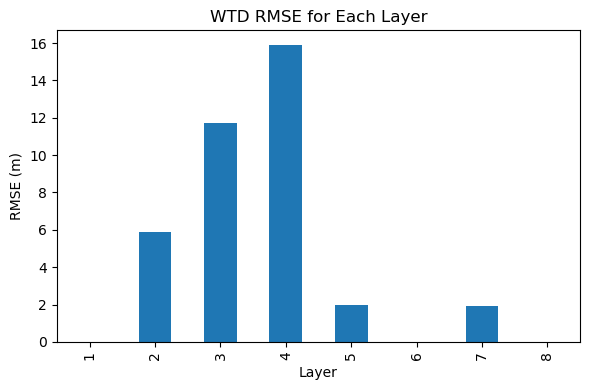

In [64]:
# ---------------------- Plot RMSE for each layer using well statistics script ----------------------

# Layer statistics run using WellStats.py script
# Usage example: python WellStats.py WS_config.xml

# Read in output csv from WellStats.py
WS_input_layers = pd.read_csv(r"..\observations\H_data\WS_input_layers.csv",sep='\t')
WS_input_layers

# PLot RMSE for each layer as a bar chart
fig, ax = plt.subplots(figsize=(6,4))
WS_input_layers.plot.bar(x='Layer', y='RMSE_wells', ax=ax, legend=False)
ax.set_ylabel('RMSE (m)')
ax.set_xlabel('Layer')
ax.set_title('WTD RMSE for Each Layer')
plt.tight_layout()

# print statistics
for _, row in WS_input_layers.iterrows():
    # skip empty layers (no data)
    if np.isnan(row['RMSE_obs']):
        continue
    print(f"Layer {int(row['Layer']):<2} | RMSE: {row['RMSE_obs']:.4f} | Data Points: {int(row['nobs'])} | Wells: {int(row['nwells'])}")